Who is doing what models:
*   Tom- L2 and Elastic Net
*   David- Basic Decision Tree
*   Elizabeth- Step-wise
*   Tommy- L1 integration
*   Koise- Full

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import statsmodels.api as sample_data

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.feature_selection import chi2, SelectKBest
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from mlxtend.classifier import StackingCVClassifier

In [2]:
def plot_roc(fpr, tpr, roc_auc, train):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if train == True:
        plt.title('Receiver Operating Characteristic for Train Data')
    else:
        plt.title('Receiver Operating Characteristic for Test Data')
    plt.legend(loc='lower right')
    plt.show()

In [3]:
def metric_report(actual, predicted):
    acc_train = accuracy_score(actual, predicted)
    prec_train = precision_score(actual, predicted)
    rec_train = recall_score(actual, predicted)

    print("Accuracy : {:.4f}".format(acc_train))
    print("Precision: {:.4f}".format(prec_train))
    print("Recall.  : {:.4f}".format(rec_train))

In [4]:
# function for model coefficents
def rpt_model_variables(model, X):
    # Get the intercept term
    intercept = model.intercept_

    # Access the coefficients (weights) of the model, i rounded them
    coefficients = np.round(model.coef_[0],decimals=4)

    # Create DataFrames for intercept and coefficients
    #df_intercept = pd.DataFrame({'feature': ['Intercept'], 'coefficient': [intercept[0]]})
    df_coefficients = pd.DataFrame({'feature': X.columns, 'coefficient': coefficients})
    df_coefficients['abs_coefficient'] = df_coefficients['coefficient'].abs()
    df_coefficients.sort_values(by='abs_coefficient', ascending=False, inplace=True)

    # if you want to add intercept to table
    #df_model = pd.concat([df_intercept, df_coefficients]).reset_index(drop=True)

    return df_coefficients

In [5]:
isp_df = pd.read_csv(r"C:\Users\trush\OneDrive\Documents\WFU Grad School Info\BAN 6025 Machine Learning\Data\isp_cleaned.csv")
isp_df.shape

(71893, 9)

In [6]:
X = isp_df.drop(columns=['churn'])
y = isp_df['churn']

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
dt_tune = DecisionTreeClassifier()

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_leaf': [1, 2, 5, 10, 20],
    'ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

grid_search = GridSearchCV(dt_tune, param_grid, cv=5)
grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

print(best_params)
print(best_estimator)

{'ccp_alpha': 0.0, 'max_depth': 40, 'min_samples_leaf': 20}
DecisionTreeClassifier(max_depth=40, min_samples_leaf=20)


In [8]:
best_dt = DecisionTreeClassifier(**best_params)

#Fit the classifier
best_dt.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=40, min_samples_leaf=20)

In [9]:
y_pred_train = best_dt.predict(x_train)
y_pred_test = best_dt.predict(x_test)

y_prob_train = best_dt.predict_proba(x_train)
y_prob_test = best_dt.predict_proba(x_test)

In [10]:
print(' -- train set -- ')

metric_report(y_train, y_pred_train)

print('')

print(' -- test set -- ')

metric_report(y_test, y_pred_test)

 -- train set -- 
Accuracy : 0.8474
Precision: 0.8826
Recall.  : 0.8370

 -- test set -- 
Accuracy : 0.8074
Precision: 0.8458
Recall.  : 0.8028


In [11]:
print(' -- train set --')
print(confusion_matrix(y_train, y_pred_train))

print('')

print(' -- test set --')
print(confusion_matrix(y_test, y_pred_test))

 -- train set --
[[21967  3561]
 [ 5213 26773]]

 -- test set --
[[5135 1180]
 [1590 6474]]


In [18]:
from sklearn.tree import export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(best_dt, filled=True, rounded=True, feature_names=X.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree_default")

'decision_tree_default.pdf'

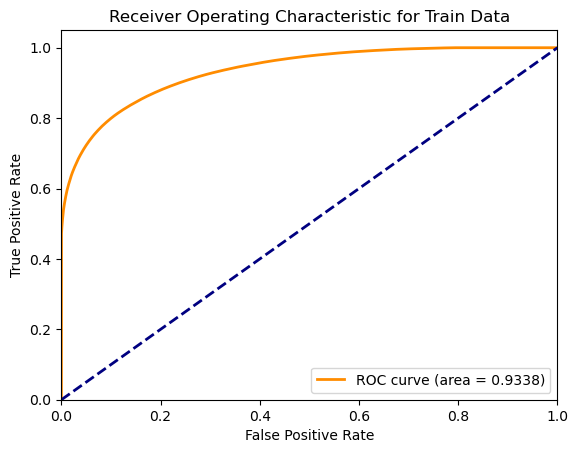

In [12]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train, y_prob_train[:,1])

plot_roc(fpr, tpr, roc_auc, True)

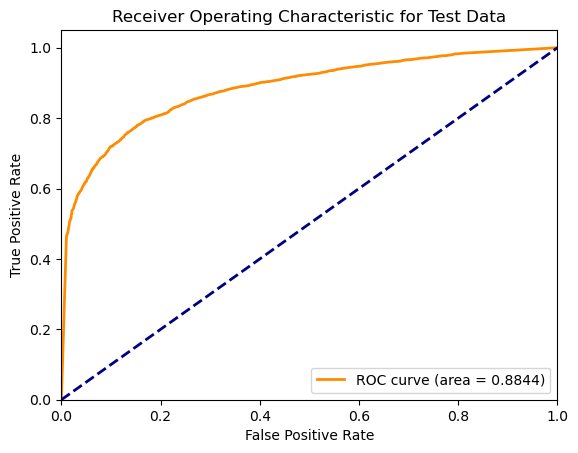

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test, y_prob_test[:,1])

plot_roc(fpr, tpr, roc_auc, False)

In [14]:
tree_imp = best_dt.feature_importances_

column_values = ['importance']

df = pd.DataFrame(data=tree_imp, columns=column_values)

df['feature'] = X.columns

df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)


   importance                      feature
5    0.394185                 download_avg
2    0.217309             subscription_age
3    0.166438                     bill_avg
1    0.102984  is_movie_package_subscriber
6    0.062636                   upload_avg
0    0.047050             is_tv_subscriber
7    0.008190          download_over_limit
4    0.001207        service_failure_count


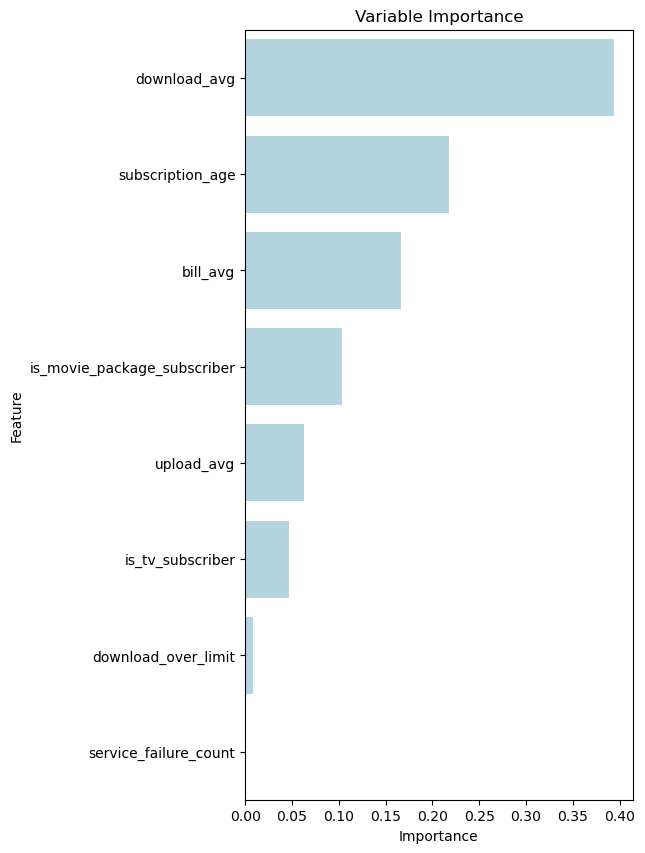

In [15]:
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()

L2 Regularization

In [16]:
lr_l2 = LogisticRegression(penalty='l2', solver='liblinear')

Elastic Net

In [17]:
lr_elastic_net = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5)

Fit both of the classifiers

In [18]:
lr_elastic_net.fit(x_train, y_train)

c:\Users\trush\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(l1_ratio=0.5, penalty='elasticnet', solver='saga')

In [19]:
lr_l2.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

Coefficients for L2

In [20]:
print('L2 Logistic Regression')
print(rpt_model_variables(lr_l2, X))

L2 Logistic Regression
                       feature  coefficient  abs_coefficient
0             is_tv_subscriber      -1.6660           1.6660
1  is_movie_package_subscriber      -0.8154           0.8154
7          download_over_limit       0.5438           0.5438
4        service_failure_count       0.1153           0.1153
2             subscription_age      -0.0872           0.0872
3                     bill_avg       0.0234           0.0234
5                 download_avg      -0.0178           0.0178
6                   upload_avg       0.0040           0.0040


Coefficients for Elastic Net

In [21]:
print('Elastic Net Logistic Regression')
print(rpt_model_variables(lr_elastic_net, X))

Elastic Net Logistic Regression
                       feature  coefficient  abs_coefficient
3                     bill_avg       0.0493           0.0493
7          download_over_limit       0.0480           0.0480
1  is_movie_package_subscriber      -0.0235           0.0235
5                 download_avg      -0.0202           0.0202
2             subscription_age      -0.0116           0.0116
4        service_failure_count       0.0115           0.0115
0             is_tv_subscriber      -0.0100           0.0100
6                   upload_avg       0.0022           0.0022


Metrics for L2

In [22]:
y_pred_train = lr_l2.predict(x_train)
y_pred_test = lr_l2.predict(x_test)

y_prob_train = lr_l2.predict_proba(x_train)
y_prob_test = lr_l2.predict_proba(x_test)

In [23]:
print(' -- train set -- ')

metric_report(y_train, y_pred_train)

print('')

print(' -- test set -- ')

metric_report(y_test, y_pred_test)

 -- train set -- 
Accuracy : 0.7341
Precision: 0.7481
Recall.  : 0.7870

 -- test set -- 
Accuracy : 0.7341
Precision: 0.7520
Recall.  : 0.7846


In [24]:
print(' -- train set --')
print(confusion_matrix(y_train, y_pred_train))

print('')

print(' -- test set --')
print(confusion_matrix(y_test, y_pred_test))

 -- train set --
[[17050  8478]
 [ 6813 25173]]

 -- test set --
[[4228 2087]
 [1737 6327]]


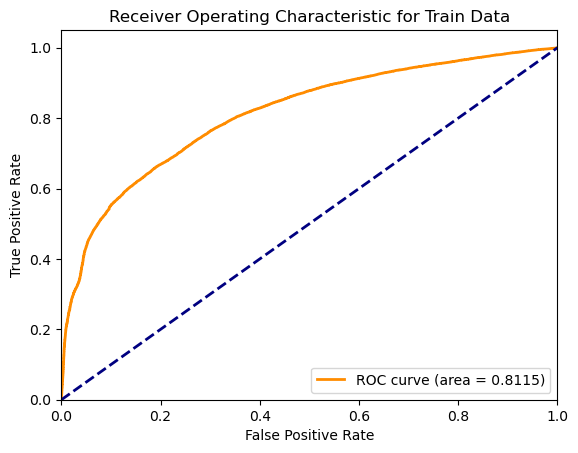

In [25]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train, y_prob_train[:,1])

plot_roc(fpr, tpr, roc_auc, True)

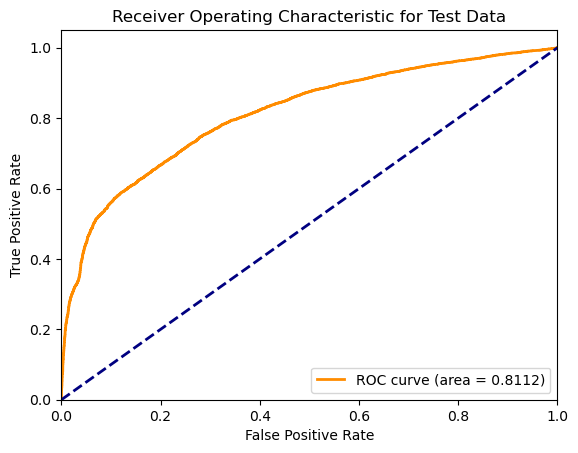

In [26]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test, y_prob_test[:,1])

plot_roc(fpr, tpr, roc_auc, False)

Metrics For Elastic Net

In [34]:
y_pred_train = lr_elastic_net.predict(x_train)
y_pred_test = lr_elastic_net.predict(x_test)

y_prob_train = lr_elastic_net.predict_proba(x_train)
y_prob_test = lr_elastic_net.predict_proba(x_test)

In [35]:
print(' -- train set -- ')

metric_report(y_train, y_pred_train)

print('')

print(' -- test set -- ')

metric_report(y_test, y_pred_test)

 -- train set -- 
Accuracy : 0.6807
Precision: 0.6913
Recall.  : 0.7692

 -- test set -- 
Accuracy : 0.6783
Precision: 0.6920
Recall.  : 0.7682


In [36]:
print(' -- train set --')
print(confusion_matrix(y_train, y_pred_train))

print('')

print(' -- test set --')
print(confusion_matrix(y_test, y_pred_test))

 -- train set --
[[14544 10984]
 [ 7383 24603]]

 -- test set --
[[3558 2757]
 [1869 6195]]


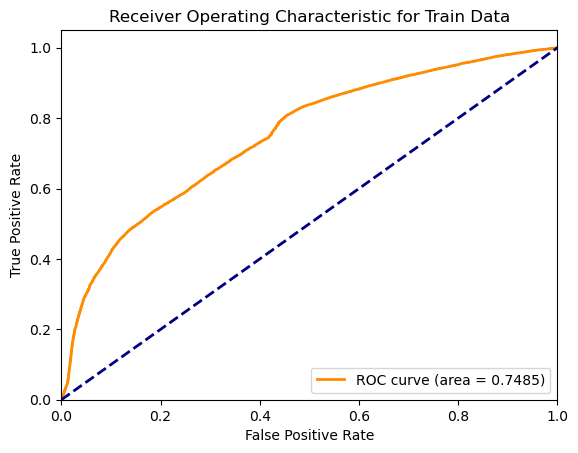

In [37]:
fpr, tpr, thresholds = roc_curve(y_train, y_prob_train[:,1])
roc_auc = roc_auc_score(y_train, y_prob_train[:,1])

plot_roc(fpr, tpr, roc_auc, True)

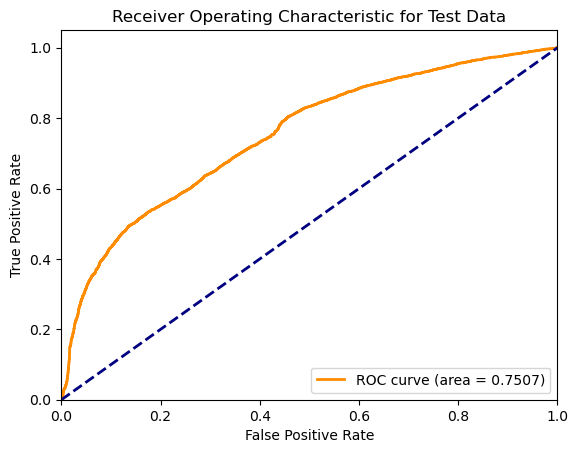

In [38]:
fpr, tpr, thresholds = roc_curve(y_test, y_prob_test[:,1])
roc_auc = roc_auc_score(y_test, y_prob_test[:,1])

plot_roc(fpr, tpr, roc_auc, False)

Full Logistic Regression

In [39]:
logit_mod = sample_data.Logit(y_train, x_train).fit()

print(logit_mod.summary())

log_reg = LogisticRegression()
log_reg.fit(x_train, y_train)

Optimization terminated successfully.
         Current function value: 0.574025
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  churn   No. Observations:                57514
Model:                          Logit   Df Residuals:                    57506
Method:                           MLE   Df Model:                            7
Date:                Mon, 18 Nov 2024   Pseudo R-squ.:                  0.1642
Time:                        09:52:12   Log-Likelihood:                -33014.
converged:                       True   LL-Null:                       -39502.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
is_tv_subscriber               -0.1460      0.020     -7.279      0.000   

c:\Users\trush\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

Making predictions for training and testing data

In [40]:
pprob_train = logit_mod.predict(x_train)
pprob_test = logit_mod.predict(x_test)

psuccess_train = (pprob_train > 0.5).astype(int)
psuccess_test = (pprob_test > 0.5).astype(int)

x_train['p_success'] = psuccess_train
x_train['p_prob'] = pprob_train

x_test['p_success'] = psuccess_test
x_test['p_prob'] = pprob_test

Confusion Matrix Full Logistic Regression

In [41]:
conf_matrix_train = confusion_matrix(y_train, psuccess_train)
conf_matrix_test = confusion_matrix(y_test, psuccess_test)

print("Confusion Matrix (Train):\n", conf_matrix_train)
print("Confusion Matrix (Test):\n", conf_matrix_test)

Confusion Matrix (Train):
 [[17301  8227]
 [ 8549 23437]]
Confusion Matrix (Test):
 [[4260 2055]
 [2136 5928]]


Full Logistic Regression Metrics

In [42]:
print(' -- train set -- ')

metric_report(y_train, psuccess_train)

print('')

print(' -- test set -- ')

metric_report(y_test, psuccess_test)

 -- train set -- 
Accuracy : 0.7083
Precision: 0.7402
Recall.  : 0.7327

 -- test set -- 
Accuracy : 0.7085
Precision: 0.7426
Recall.  : 0.7351


ROC Curve for Full Logistic Regression

In [43]:
fpr_train, tpr_train, _ = roc_curve(y_train, pprob_train)
fpr_test, tpr_test, _ = roc_curve(y_test, pprob_test)

auc_train = roc_auc_score(y_train, pprob_train)
auc_test = roc_auc_score(y_test, pprob_test)

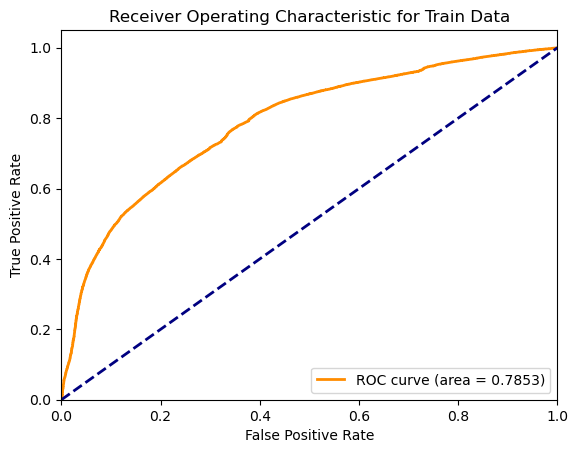

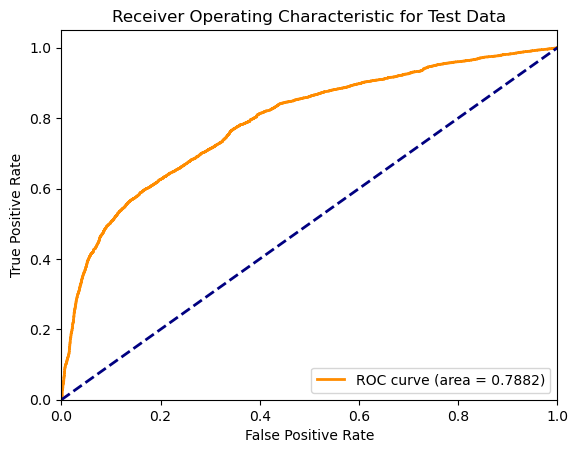

In [44]:
plot_roc(fpr_train, tpr_train, auc_train, True)
plot_roc(fpr_test, tpr_test, auc_test, False)

Basic Decision Tree

In [45]:
isp_df_tree = isp_df
isp_df_tree.head()

,is_tv_subscriber,is_movie_package_subscriber,subscription_age,bill_avg,service_failure_count,download_avg,upload_avg,download_over_limit,churn
0,1,0,11.95,25,0,8.4,2.3,0,0
1,0,0,8.22,0,0,0.0,0.0,0,1
2,1,0,8.91,16,0,13.7,0.9,0,1
3,0,0,6.87,21,1,0.0,0.0,0,1
4,0,0,6.39,0,0,0.0,0.0,0,1


In [47]:
isp_df_tree['churn'] = isp_df_tree['churn'].astype('category')
x_tree = isp_df_tree.drop(columns=['churn'])
y_tree = isp_df_tree['churn']

x_train_tree, x_test_tree, y_train_tree, y_test_tree = train_test_split(x_tree, y_tree, test_size=0.2, random_state=35)


In [48]:
# create an instance of a decision tree classifier

dt = DecisionTreeClassifier(max_depth = 5, min_samples_leaf=10, ccp_alpha = 0)

# fit the model to the training data
dt.fit(x_train_tree, y_train_tree)

# this code can be used to produce a textual representation of the tree if desired
#text_rep = tree.export_text(dt)
#print(text_rep)


DecisionTreeClassifier(ccp_alpha=0, max_depth=5, min_samples_leaf=10)

In [49]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# visualize the decision tree
dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=x_tree.columns, class_names=['0', '1'])
graph = graphviz.Source(dot_data)
graph.render("decision_tree")


'decision_tree.pdf'

In [51]:
# make predictions on the training and test data
y_pred_train_tree = dt.predict(x_train_tree)
y_pred_test_tree = dt.predict(x_test_tree)

y_prob_train_tree = dt.predict_proba(x_train_tree)
y_prob_test_tree = dt.predict_proba(x_test_tree)

In [52]:
# calculate the accuracy, precision, and recall scores
acc_train = accuracy_score(y_train_tree, y_pred_train_tree)
prec_train = precision_score(y_train_tree, y_pred_train_tree)
rec_train = recall_score(y_train_tree, y_pred_train_tree)

# print the scores
print(" -- train set -- ")
print("Accuracy : {:.4f}".format(acc_train))
print("Precision: {:.4f}".format(prec_train))
print("Recall.  : {:.4f}".format(rec_train))
print("")

# calculate the accuracy, precision, and recall scores
acc_test = accuracy_score(y_test_tree, y_pred_test_tree)
prec_test = precision_score(y_test_tree, y_pred_test_tree)
rec_test = recall_score(y_test_tree, y_pred_test_tree)

print(" -- test set -- ")
print("Accuracy : {:.4f}".format(acc_test))
print("Precision: {:.4f}".format(prec_test))
print("Recall.  : {:.4f}".format(rec_test))

 -- train set -- 
Accuracy : 0.7693
Precision: 0.8752
Recall.  : 0.6838

 -- test set -- 
Accuracy : 0.7696
Precision: 0.8753
Recall.  : 0.6819


In [53]:
# confusion matrix
conf_matrix = confusion_matrix(y_pred_train_tree, y_train_tree)
print(conf_matrix)

# Generate confusion matrix for test set
conf_matrix = confusion_matrix(y_pred_test_tree, y_test_tree)
print(conf_matrix)

[[22316 10141]
 [ 3126 21931]]
[[5626 2538]
 [ 775 5440]]


ROC Curves for Basic Decision Tree

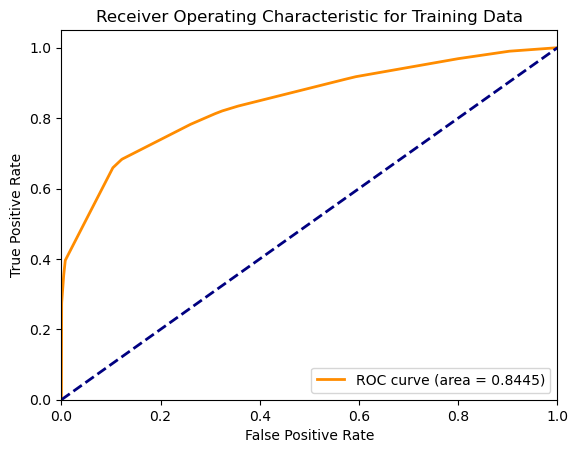

In [54]:
# Generate ROC curve for training data

fpr, tpr, thresholds = roc_curve(y_train_tree.cat.codes, y_prob_train_tree[:,1])
roc_auc = roc_auc_score(y_train_tree.cat.codes, y_prob_train_tree[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Training Data')
plt.legend(loc='lower right')
plt.show()

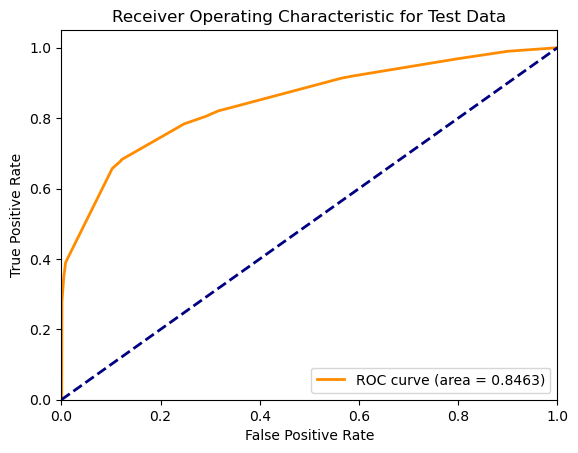

In [55]:
# Generate ROC curve for test data
fpr, tpr, thresholds = roc_curve(y_test_tree.cat.codes, y_prob_test_tree[:,1])
roc_auc = roc_auc_score(y_test_tree.cat.codes, y_prob_test_tree[:,1])

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Test Data')
plt.legend(loc='lower right')
plt.show()


Feature Importance for Decision Tree

   importance                      feature
5    0.604924                 download_avg
1    0.152873  is_movie_package_subscriber
3    0.105483                     bill_avg
0    0.074851             is_tv_subscriber
2    0.061868             subscription_age
4    0.000000        service_failure_count
6    0.000000                   upload_avg
7    0.000000          download_over_limit


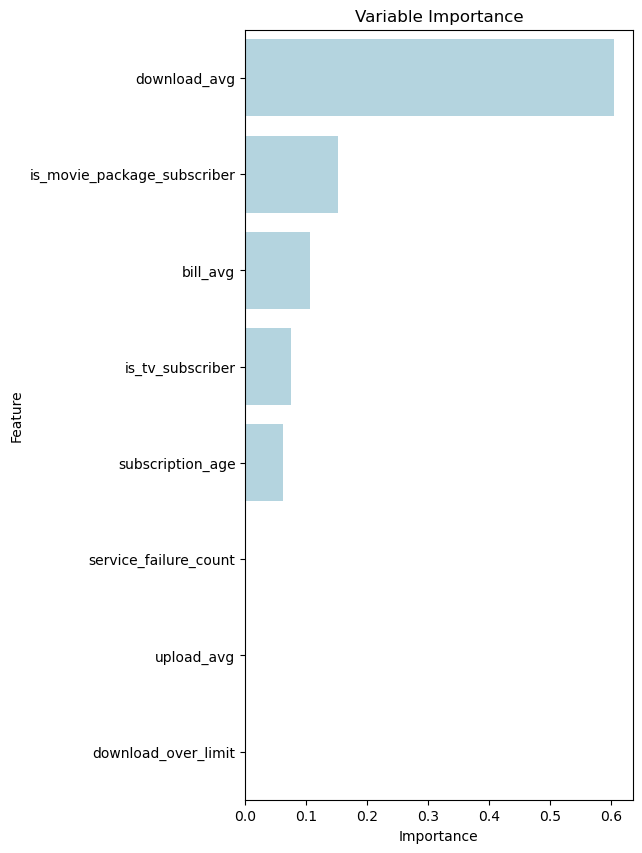

In [56]:
#calculate feature importance
tree_imp = dt.feature_importances_

#create a data frame with feature names

# creating a list of column names
column_values = ['importance']

# creating the dataframe
df = pd.DataFrame(data = tree_imp,
                  columns = column_values)
df['feature']=X.columns

#sort data so features with largest importance values are at the top
df2 = df.sort_values(by=['importance'], ascending=False)

print(df2)

#Create variable importance plot
plt.figure(figsize=(5, 10))
plt.title('Variable Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
sns.barplot(data=df2,
            y=df2['feature'],
            x=df2['importance'], color="lightblue")

plt.show()